In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import GPR,MSD_functions
import numpy as np
import matplotlib.pyplot as plt


Here we will generate a test-dataset akin to the one in this paper:https://www.science.org/doi/10.1126/science.abn6583. We will generate values at a fine time-resolution compared to the one in the paper so we can see what the predictions do between observations

In [2]:

ntracks = 100
noise = [48,47,120] # µm
Gamma = 2.4*1e3*np.sqrt(60)/3 # µm^2/sqrt(min)
J = (357)**2/3 # µm^2
ndims = 3
nanfrac=0.1
tmin,tmax = 0,6.0*60 # minutes
dt = 1/3 # minutes (20 sec)
ntimes = int((tmax - tmin) / dt) + 1
fine_factor = 10
times = np.linspace(tmin,tmax,ntimes*fine_factor)

regressor = GPR.GPR(times,MSD_functions.Rouse_MSD,ndims)

theta = np.array([Gamma,J]*ndims + noise)
true_dat,noisy_dat = regressor.sample_prior(theta, ntracks,nanfrac=nanfrac,seed=12)
downsampled_times = times[::fine_factor]
downsampled_noisy_dat = noisy_dat[:,::fine_factor]


XlaRuntimeError: INTERNAL: cuSolver internal error

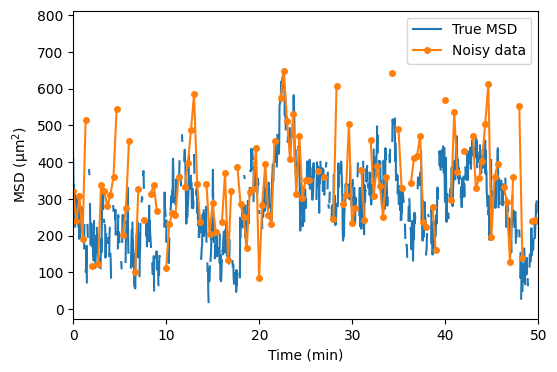

In [ ]:
track_ind = 0
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(times, np.linalg.norm(true_dat[track_ind], axis=-1), label='True distance')
ax.plot(downsampled_times,np.linalg.norm(downsampled_noisy_dat[track_ind], axis=-1), '-o', label='Noisy data', markersize=4)

ax.set(xlim=(0,50), xlabel='Time (min)', ylabel='Enhancer-promoter distance (nm$^2$)')
ax.legend()

We then perform posterior predictsions on the data to see how well we can recover the true underlying curve.

In [11]:
# perform posterior prediction
pred_regressor = GPR.GPR(downsampled_times,MSD_functions.Rouse_MSD,ndims)
theta = np.array([Gamma,J] + noise)
p_mean,p_var = pred_regressor.Predict(theta,times,downsampled_noisy_dat)



Predicting:   0%|          | 0/2 [00:00<?, ?it/s]

To get a sense for the reconstruction quality we will plot the components of the e-p separation vector along with the z-score of the prediction for each component

[Text(0.5, 0, 'Z-score'), Text(0, 0.5, 'Z-score Component 1')]

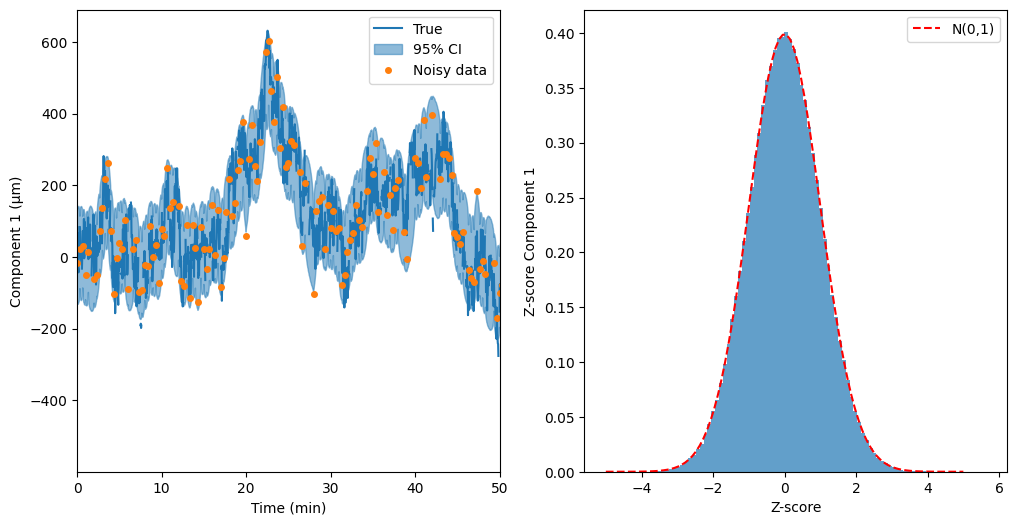

In [26]:
z_scores = ((p_mean - true_dat) / np.sqrt(p_var)).reshape(-1, ndims) # shape (ntracks*ntimes, ndims)
fig,ax = plt.subplots(1,2,figsize=(12,6))
dim=0

ax[0].plot(times, true_dat[track_ind,:,dim], label='True')

ax[0].fill_between(times,
                        p_mean[track_ind,:,dim] - 2*np.sqrt(p_var[track_ind,:,dim]),
                        p_mean[track_ind,:,dim] + 2*np.sqrt(p_var[track_ind,:,dim]),
                        color='C0', alpha=0.5, label='95% CI')
ax[0].plot(downsampled_times, downsampled_noisy_dat[track_ind,:,dim], 'o', label='Noisy data', markersize=4)
ax[0].set(xlabel='Time (min)', ylabel=f'Component {dim+1} (µm)',xlim=(0,50))
ax[0].legend()

ax[1].hist(z_scores[:,dim], bins=100, density=True, alpha=0.7)
ax[1].plot(np.linspace(-5,5,100), 1/np.sqrt(2*np.pi)*np.exp(-0.5*np.linspace(-5,5,100)**2), 'r--', label='N(0,1)')
ax[1].legend()
ax[1].set(xlabel='Z-score', ylabel=f'Z-score Component {dim+1}')

This shows that each component is well-reconstructed. We can also use these to get confidence bands on the distance by using the numerical 